<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>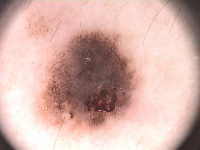</td><td>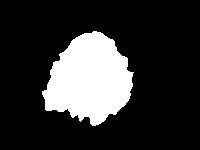</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
import numpy as np
import random
import pandas as pd
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True


In [2]:
#! wget https://www.dropbox.com/s/bebos6xr02rf8mq/PH2Dataset.rar

In [3]:
#get_ipython().system_raw("unrar x /kaggle/input/p2data")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/kaggle/input/p2data/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

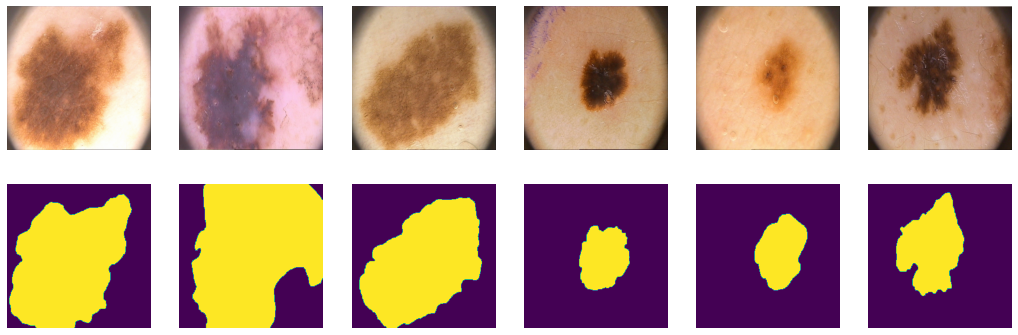

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 15
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

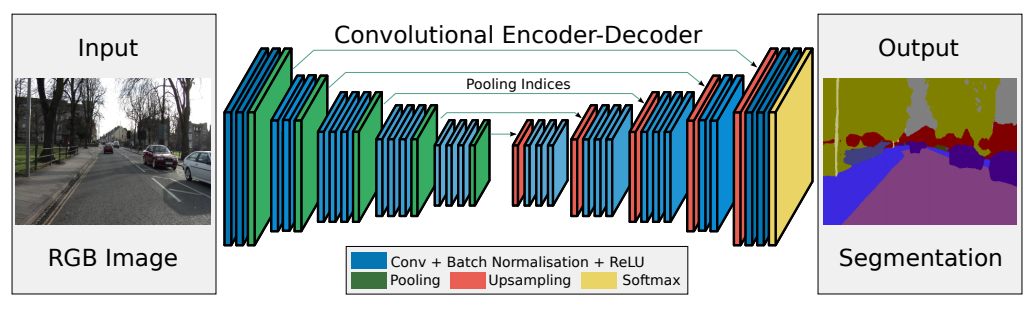

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
!pip install torchsummary
from torchsummary import summary

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
max_epochs = 100

In [14]:
def conv3x3(in_channels, out_channels, stride=1, groups=1, dilation=1):
        """3x3 convolution with padding"""
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
                            conv3x3(3, 64),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            conv3x3(64, 64),
                            nn.BatchNorm2d(64),
                            nn.ReLU()
                            )                
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                            conv3x3(64, 128),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            conv3x3(128, 128),
                            nn.BatchNorm2d(128),
                            nn.ReLU()
                            )      
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                            conv3x3(128, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            conv3x3(256, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            conv3x3(256, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU()
                            )      
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                            conv3x3(256, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU()
                            )      
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True) # 32 -> 16

        self.enc_conv4 = nn.Sequential(
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU()
                            )      
        self.pool4 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True) 
        
        # bottleneck

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU())   
        self.upsample1 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv1 = nn.Sequential(
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU())     
        self.upsample2 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
                            conv3x3(256, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            conv3x3(256, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            conv3x3(256, 128),
                            nn.BatchNorm2d(128),
                            nn.ReLU())     
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv3 = nn.Sequential(
                            conv3x3(128, 128),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            conv3x3(128, 64),
                            nn.BatchNorm2d(64),
                            nn.ReLU())     
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv4 = nn.Sequential(
                            conv3x3(64, 64),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            conv3x3(64, 1))#,
                            #nn.BatchNorm2d(1),
                            #nn.Sigmoid())     

    def forward(self, x):
        # encoder
        e0, i0 = self.pool0(self.enc_conv0(x))
        e1, i1 = self.pool1(self.enc_conv1(e0))
        e2, i2 = self.pool2(self.enc_conv2(e1))
        e3, i3 = self.pool3(self.enc_conv3(e2))
        e4, i4 = self.pool4(self.enc_conv4(e3))

        # bottleneck

        # decoder
        d0 = self.dec_conv0(self.upsample0(e4,i4))
        d1 = self.dec_conv1(self.upsample1(d0,i3))
        d2 = self.dec_conv2(self.upsample2(d1,i2))
        d3 = self.dec_conv3(self.upsample3(d2,i1))
        d4 = self.dec_conv4(self.upsample4(d3,i0))  # no activation
        return d4

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou
    

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_pred, y_real):
    
    return (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, visualize=True):
    torch.cuda.empty_cache()
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    losses_tr = []
    losses_val = []
    val_scores = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss_tr = 0
        avg_loss_val = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            inputs = X_batch.to(device)
            labels = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred_tr = model(X_batch.to(device))
            loss = loss_fn(Y_pred_tr, labels) # forward-pass
            loss.backward()
            opt.step()
            # calculate loss to show the user
            avg_loss_tr += loss / len(data_tr)
        losses_tr.append(loss)
            
            
        toc = time()
        print('loss: %f' % avg_loss_tr)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu  
        val_loss = loss_fn((Y_hat), Y_val)
        val_score = iou_pytorch((Y_hat > 0.5), Y_val).mean()
        avg_loss_val += val_loss / len(data_val)
        losses_val.append(avg_loss_val)
        val_scores.append(val_score)
        #print('loss: %f' % avg_loss_val)
        #print('score: %f' % val_score)
        clear_output(wait=True)
        if visualize:
            # Visualize tools
            for k in range(6):
                plt.subplot(3, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(3, 6, k+7)
                plt.imshow(np.rollaxis(Y_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
                plt.title('Label')
                plt.axis('off')

                plt.subplot(3, 6, k+13)
                plt.imshow((Y_hat[k, 0] > 0.2).int(), cmap='gray')
                plt.title('Output')
                plt.axis('off')

                plt.suptitle('%d / %d - train loss: %f val loss: %f score %f' % (epoch+1, epochs, avg_loss_tr, avg_loss_val, val_score))#, 'val loss: %f' % (avg_loss_val))
            plt.show()
    return losses_tr, losses_val, val_scores, (toc - tic)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(model, data):
    with torch.no_grad():
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            model.eval()  # testing mode
            Y_pred = model(X_batch).cpu()
    return np.array(torch.sigmoid(Y_pred))

In [20]:
def score_model(model, metric, data, threshold = 0.5):
    torch.cuda.empty_cache()
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric((Y_pred > 0.5), Y_label.to(device)).mean().item()
    return scores/len(data)

In [21]:
#stop

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


Протестируем SegNet c различными оптимизаторами на 20 эпохах:

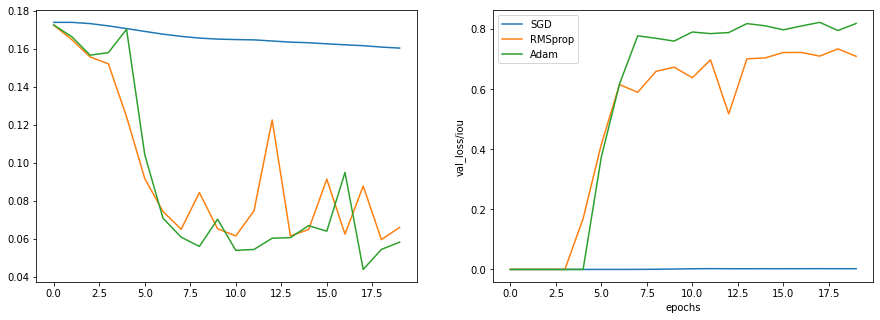

In [22]:
# картинки не выводятся т.к. для подбора параметров в цикле они не показательны
# (в функцию train добавлен флаг visualize=False)
lr = 1e-4
opts = ['SGD', 'RMSprop', 'Adam']
opt_logs = {}
opt_logs['metric'] = ['val_loss', 'iou', 'val_score', 'test_score']
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for opt in opts:
    model = SegNet().to(device)
    if opt == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.9)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = train(model, optimizer, bce_loss, 20, data_tr, data_val, visualize=False)
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    opt_logs[opt] = [history[1], history[2], val_score, test_score]
    axes[0].plot(history[1], label=opt)
    axes[1].plot(history[2], label=opt)
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val_loss/iou")
plt.savefig('data/segnet_optimizers.png')
plt.show()

In [23]:
opt_scores = pd.DataFrame(opt_logs)
print('Сравнительная таблица оптимизаторов на валидационном и тестовом сете')
opt_scores = opt_scores[2:].set_index('metric')
opt_scores

Сравнительная таблица оптимизаторов на валидационном и тестовом сете


,SGD,RMSprop,Adam
metric,,,
val_score,0.00418009,0.762549,0.829081
test_score,0.00642521,0.735119,0.770912


SegNet с лучшим оптимизатором на 100 эпохах:

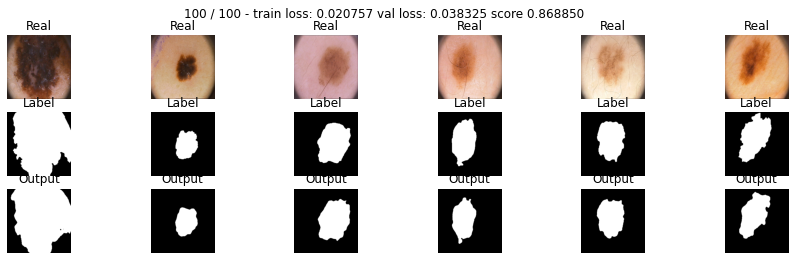

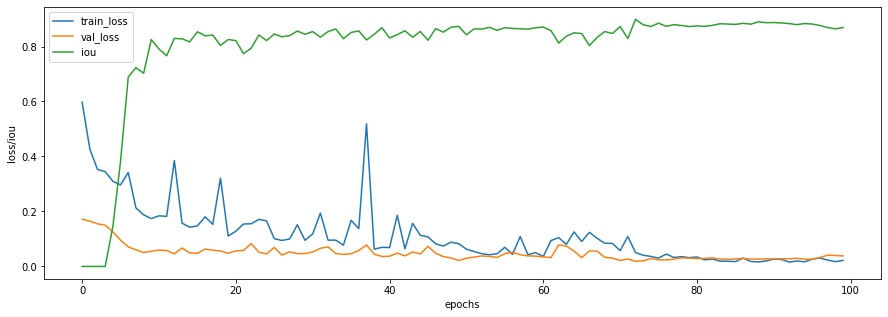

Score на валидационном сете:0.85
Score на тестовом сете:0.82


<Figure size 1080x288 with 0 Axes>

In [24]:
segnet_bce = SegNet().to(device)
optimizer = torch.optim.Adam(segnet_bce.parameters(), lr=1e-4)
history = train(segnet_bce, optimizer, bce_loss, 100, data_tr, data_val)
b_val_iou = score_model(segnet_bce, iou_pytorch, data_val)
b_test_iou = score_model(segnet_bce, iou_pytorch, data_ts)
plt.figure(figsize=(15, 5))
plt.plot(history[0], label="train_loss")
plt.plot(history[1], label="val_loss")
plt.plot(history[2], label="iou")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/iou")
plt.show()
plt.savefig('data/segnet_adam.png')
print(f'Score на валидационном сете:{b_val_iou:0.2f}')
print(f'Score на тестовом сете:{b_test_iou:0.2f}');

По данному графику можно сделать вывод, что примерно 50 эпох будет достаточно, далее возможно переобучение модели.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [25]:
def dice_loss(y_pred, y_real):
    y_pred = torch.flatten(torch.sigmoid(y_pred))
    y_real = torch.flatten(y_real)
    smooth = 1e-8
    num = 2 * torch.sum(y_pred * y_real)
    den = torch.sum(y_pred) + torch.sum(y_real) 
    res = 1 - (1 / 256*256) * (num + smooth) / (den + smooth)
    return res
    

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [26]:
def focal_loss(y_pred, y_real, eps=1e-8, gamma=2):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.flatten()
    y_real = y_real.flatten()
    loss = 1 - torch.mean((1 - y_pred) ** gamma * y_real * torch.log(torch.clamp(y_pred, min=eps)) + \
                          (1 - y_real) * torch.log(torch.clamp((1 - y_pred), min=eps)))
    return loss

Проводим тестирование различных функций потерь:

In [27]:
loss_funcs = {'name' : ['bce_loss', 'dice_loss', 'focal_loss'],
              'param': [bce_loss, dice_loss, focal_loss]}

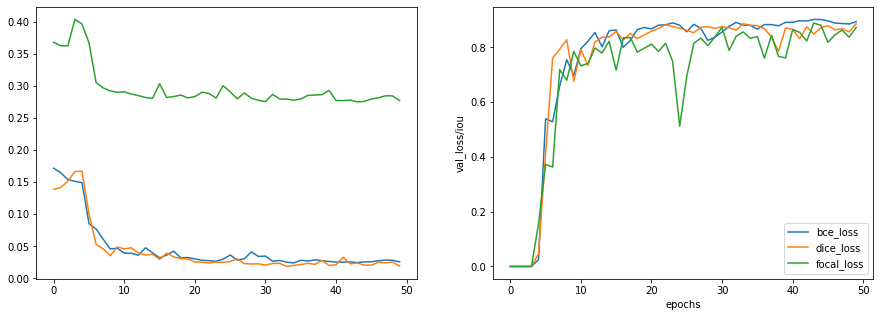

In [28]:
# картинки не выводятся т.к. для подбора параметров в цикле они не показательны
# (в функцию train добавлен флаг visualize=False)

segnet_loss_logs = {}
segnet_loss_logs['metric'] = ['val_loss', 'iou', 'val_score', 'test_score']
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for i in range(len(loss_funcs['param'])):
    model = SegNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    history = train(model, optimizer, loss_funcs['param'][i], 50, data_tr, data_val, visualize=False)
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    segnet_loss_logs[loss_funcs['name'][i]] = [history[1], history[2], val_score, test_score]
    axes[0].plot(history[1], label=loss_funcs['name'][i])
    axes[1].plot(history[2], label=loss_funcs['name'][i])
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val_loss/iou")
plt.savefig('data/segnet_losses.png')
plt.show()

In [29]:
segnet_loss_scores = pd.DataFrame(segnet_loss_logs)
print('Сравнительная таблица различных функций потерь на валидационном и тестовом сете')
segnet_loss_scores = segnet_loss_scores[2:].set_index('metric')
segnet_loss_scores

Сравнительная таблица различных функций потерь на валидационном и тестовом сете


,bce_loss,dice_loss,focal_loss
metric,,,
val_score,0.877938,0.861216,0.85962
test_score,0.855441,0.835538,0.820872


Тренировка модели с лучшими параметрами:

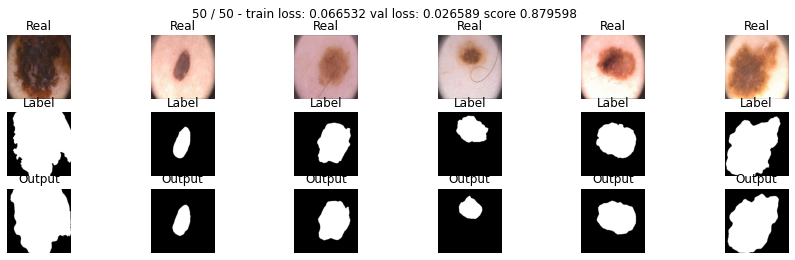

Score на валидационном сете : 0.8439992964267731
Score на тестовом сете : 0.8246432095766068
Время обучения модели : 8.328869342803955


In [30]:
best_segnet = SegNet().to(device)
optimizer = optim.Adam(best_segnet.parameters(), lr=1e-4)
history = train(best_segnet, optimizer, bce_loss, 50, data_tr, data_val, visualize=True)
s_val_score = score_model(best_segnet, iou_pytorch, data_val)
s_test_score = score_model(best_segnet, iou_pytorch, data_ts)
segnet_time = history[3]
print(f'Score на валидационном сете : {s_val_score}')
print(f'Score на тестовом сете : {s_test_score}')
print(f'Время обучения модели : {segnet_time}')

In [31]:
#stop

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

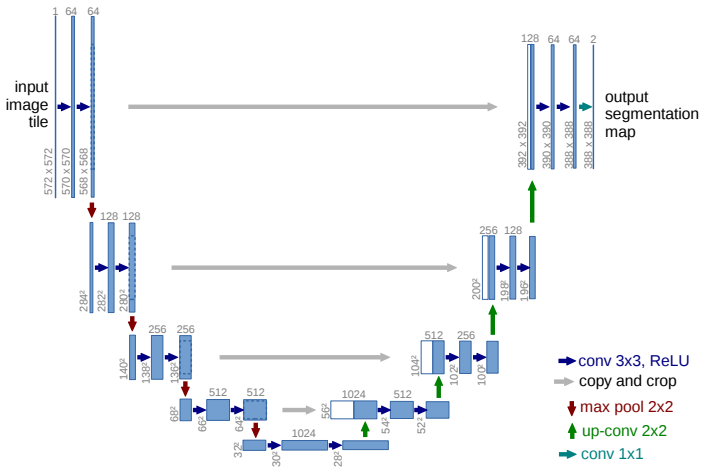

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [32]:
def up2x2(mode, in_channels, out_channels):
            if mode == 'upsample':
                return nn.Upsample(scale_factor=2)
            if mode == 'transpose':
                return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

In [33]:
class UNet(nn.Module):
    
    def __init__(self, mode):
        super().__init__()
        
        self.mode = mode

        self.enc_conv0 = nn.Sequential(
                            conv3x3(3, 64),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            conv3x3(64, 64),
                            nn.BatchNorm2d(64),
                            nn.ReLU()
                            )                
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                            conv3x3(64, 128),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            conv3x3(128, 128),
                            nn.BatchNorm2d(128),
                            nn.ReLU()
                            )      
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                            conv3x3(128, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            conv3x3(256, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU()
                            )      
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                            conv3x3(256, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU()
                            )      
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU(), 
                            conv3x3(512, 512),
                            nn.BatchNorm2d(512),
                            nn.ReLU()
                            )      

        # decoder (upsampling)
    
        self.upsample0 = up2x2(self.mode, 512, 512)
        self.dec_conv0 = nn.Sequential(
                            conv3x3(1024, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            conv3x3(256, 256),
                            nn.BatchNorm2d(256),
                            nn.ReLU())   
        
        self.upsample1 = up2x2(self.mode, 256, 256)
        self.dec_conv1 = nn.Sequential(
                            conv3x3(512, 128),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            conv3x3(128, 128),
                            nn.BatchNorm2d(128),
                            nn.ReLU())  
        
        self.upsample2 = up2x2(self.mode, 128, 128)
        self.dec_conv2 = nn.Sequential(
                            conv3x3(256, 64),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            conv3x3(64, 64),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
        
        
        self.upsample3 = up2x2(self.mode, 64, 64)
        self.dec_conv3 = nn.Sequential(
                            conv3x3(128, 1),
                            nn.BatchNorm2d(1),
                            nn.ReLU(),
                            conv3x3(1, 1),
                            nn.BatchNorm2d(1))
                            #nn.ReLU())
        #self.conv1x1 = nn.Conv2d(1, 1, kernel_size=1)
                            #nn.Sigmoid())

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_1 = self.pool0(e0)
        e1 = self.enc_conv1(e0_1)
        e1_1 = self.pool1(e1)
        e2 = self.enc_conv2(e1_1)
        e2_1 = self.pool2(e2)
        e3 = self.enc_conv3(e2_1)
        e3_1 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_1)

        # decoder
        d0 = self.upsample0(b)
        d0_1 = torch.cat([d0, e3], dim=1)
        d0_2 = self.dec_conv0(d0_1)
        
        
        d1 = self.upsample1(d0_2)
        d1_1 = torch.cat([d1, e2], dim=1)
        d1_2 = self.dec_conv1(d1_1)
        
        
        d2 = self.upsample2(d1_2)
        d2_1 = torch.cat([d2, e1], dim=1)
        d2_2 = self.dec_conv2(d2_1)
        
        d3 = self.upsample3(d2_2)
        d3_1 = torch.cat([d3, e0], dim=1)
        d3_2 = self.dec_conv3(d3_1)
        
        #d4 = self.conv1x1(d3_2)
        
        return d3_2

Тренировка Unet с различным типом апсемплинга:

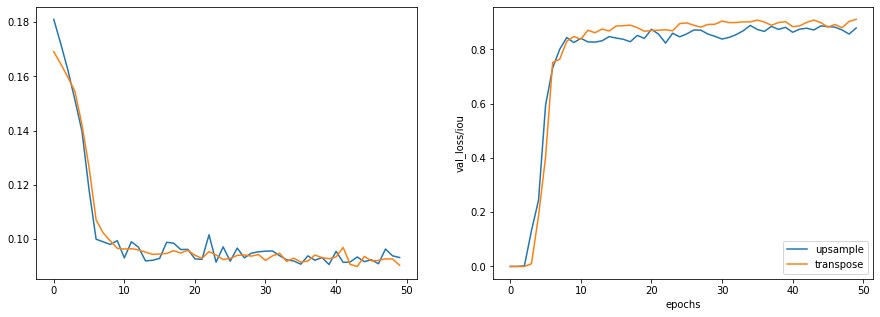

In [34]:
# картинки не выводятся т.к. для подбора параметров в цикле они не показательны
# (в функцию train добавлен флаг visualize=False)
up_modes = ['upsample', 'transpose']
mode_logs = {}
mode_logs['metric'] = ['val_loss', 'iou', 'val_score', 'test_score']
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for mode in up_modes:
    model = UNet(mode).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    history = train(model, optimizer, bce_loss, 50, data_tr, data_val, visualize=False)
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    mode_logs[mode] = [history[1], history[2], val_score, test_score]
    axes[0].plot(history[1], label=mode)
    axes[1].plot(history[2], label=mode)
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val_loss/iou")
plt.savefig('data/unet_modes.png')
plt.show()

In [35]:
mode_scores = pd.DataFrame(mode_logs)
print('Сравнительная таблица разных типов апсемплинга на валидационном и тестовом сете')
mode_scores = mode_scores[2:].set_index('metric')
mode_scores

Сравнительная таблица разных типов апсемплинга на валидационном и тестовом сете


,upsample,transpose
metric,,
val_score,0.868187,0.866583
test_score,0.779269,0.802383


Тренировка модели с различными функциями потерь:

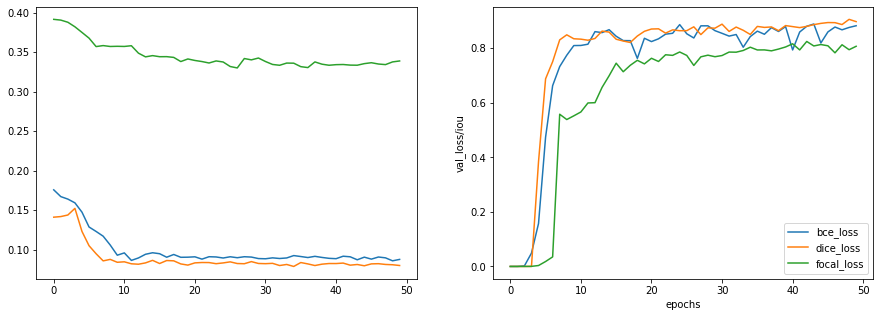

In [36]:
# картинки не выводятся т.к. для подбора параметров в цикле они не показательны
# (в функцию train добавлен флаг visualize=False)
unet_loss_logs = {}
unet_loss_logs['metric'] = ['val_loss', 'iou', 'val_score', 'test_score']
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for i in range(len(loss_funcs['param'])):
    model = UNet(mode='transpose').to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    history = train(model, optimizer, loss_funcs['param'][i], 50, data_tr, data_val, visualize=False)
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    unet_loss_logs[loss_funcs['name'][i]] = [history[1], history[2], val_score, test_score]
    axes[0].plot(history[1], label=loss_funcs['name'][i])
    axes[1].plot(history[2], label=loss_funcs['name'][i])
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val_loss/iou")
plt.savefig('data/unet_losses.png')
plt.show()

In [37]:
unet_loss_scores = pd.DataFrame(unet_loss_logs)
print('Сравнительная таблица разных функций потерь на валидационном и тестовом сете')
unet_loss_scores = unet_loss_scores[2:].set_index('metric')
unet_loss_scores

Сравнительная таблица разных функций потерь на валидационном и тестовом сете


,bce_loss,dice_loss,focal_loss
metric,,,
val_score,0.874754,0.88938,0.849565
test_score,0.828184,0.835269,0.803936


Тренировка модели с лучшими параметрами:

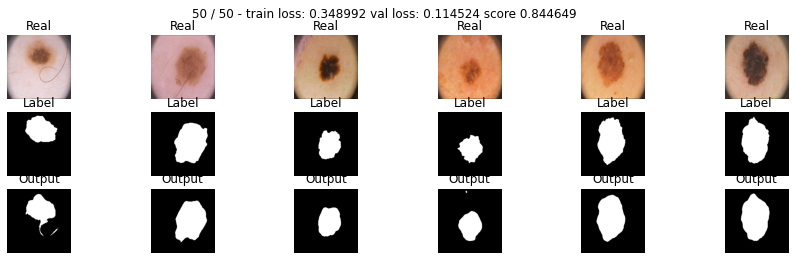

Score на валидационном сете : 0.8581490963697433
Score на тестовом сете : 0.8202134072780609
Время обучения модели : 7.033274173736572


In [38]:
best_unet = UNet(mode='transpose').to(device)
optimizer = optim.Adam(best_unet.parameters(), lr=1e-4)
history = train(best_unet, optimizer, dice_loss, 50, data_tr, data_val)
u_val_score = score_model(best_unet, iou_pytorch, data_val)
u_test_score = score_model(best_unet, iou_pytorch, data_ts)
unet_time = history[3]
print(f'Score на валидационном сете : {u_val_score}')
print(f'Score на тестовом сете : {u_test_score}')
print(f'Время обучения модели : {unet_time}')

In [39]:
models = pd.DataFrame({'metric': ['Validation score', 'Test score', 'Training time/epoch'], 
                       'SegNet': [s_val_score, s_test_score, segnet_time], 
                       'UNet': [u_val_score, u_test_score, unet_time]}
                     ).set_index('metric')

# Отчет (6 баллов)
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.

Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

________________________________________________________________________________________________________

Цель исследования:
1. Изучение и сравнение архитектуры двух моделей(SegNet, Unet) на примере задачи семантической сегментации
2. Сравнение инференса данных моделей при использовании 
    - различных оптимизаторов 
    - функций потерь
    - типов апсемплинга
3. Определение лучшей модели и конфигурации
4. Cравнение параметров и времени обучения.



-- примечание: без запуска ноутбука графики в отчете ниже могут не загрузиться, т.к. они формируются и сохраняются при выполнении ячеек выше(есть в pdf) --

**1. SegNet и Unet**

Обе представленные архитектуры моделей относятся к типу encoder-decoder. Отличительной особенностью SegNet является maxunpooling с использованием индексов полученных на фазе энкодинга. Unet в свою очередь имеет преимущество в конкатенации выхода симметричного слоя энкодера и декодера, что позволяет получить дополнительную информацию.

**2.Эксперименты с параметрами моделей**

*2.1 SegNet*

Было произведено тестирование модели при использовании различных оптимизаторов на 20 эпохах. 

В результате было выявлено, что лучший перфоманс как по скорости сходимости алгоритма так и по метрике показал оптимизатор Adam с адаптивным learning rate. 

Что еще можно реализовать: для сходимости при использовании SGD необходим дальнейший подбор параметров и добавление scheduler с целью адаптирования learning rate(впрочем для Adam добавление scheduler с глобальным изменением lr так же могло немного улучшить результат)
       
                       SegNet validation loss                                 SegNet iou

<img src='data/segnet_optimizers.png'/>

Эмпирическим путем было найдено оптимальное значение для количества эпох - 50, выше которого начинается переобучение. 

Поэтому все остальные эксперименты были проведены с использованием этого значения, для обеспечения соотносимости результатов. 

<img src='data/segnet_adam.png'/>

Среди трех различных функций потерь (bce loss, dice loss и focal loss) наилучший результат показала bce loss

                       SegNet validation loss                                 SegNet iou


<img src='data/segnet_losses.png'/>

*2.2 UNet*

Для архитектуры UNet были имплементированы два вида апсемплинга(обычный Upsample и TransposeConv2d с обучаемыми параметрами). 

Лучший результат показал TransposeConv2d, хотя различия не так существенны, при том, что обычный upsample требует меньше ресурсов.

                          UNet validation loss                                 UNet iou
<img src='data/unet_modes.png'/>

Сравнение различный функций потерь для UNet выявило более высокий score при использовании dice loss, хотя и с незначительным отрывом от bce loss

                       UNet validation loss                                 UNet iou
<img src='data/unet_losses.png'/>

**3. Итоги**

По результам исследования были выбраны две лучшие конфигурации моделей и параметров для сравнения.

In [40]:
print('Параметры лучшей конфигурации SegNet с bce loss и Adam optimizer')
summary(best_segnet.cuda(), (3, 256, 256))
print(f'Время обучения SegNet : {segnet_time}')

Параметры лучшей конфигурации SegNet с bce loss и Adam optimizer
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,728
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,456
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13   

In [41]:
print('Параметры лучшей конфигурации UNet:')
summary(best_unet.cuda(), (3, 256, 256))
print(f'Время обучения Unet: {unet_time}')

Параметры лучшей конфигурации UNet:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,728
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,456
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
   

Сравнительная таблица метрик на валидации и тесте, а так же времени обучения моделей

In [42]:
models

,SegNet,UNet
metric,,
Validation score,0.843999,0.858149
Test score,0.824643,0.820213
Training time/epoch,8.328869,7.033274


Пример изображений сегментированных с помощью SegNet :

<img src='data/segnet_img.png'/>

Пример изображений сегментированных с помощью UNet :

<img src='data/unet_img.png'/>

При сравнении лучших конфигураций SegNet и UNet можно сделать вывод, что UNet является более эффективной архитектурой для решения данной задачи, т.к. она показала хороший скор на валидационном и тестовом датасете, а так же быстрее, имеет меньше обучаемых параметров, и с точки зрения визуальной оценки качества сегментации дает более четкие очертания маски.

**4. Вывод**

Таким образом, в результате проведенного исследования было установлено, что наилучшим образом в контексте решения задачи семантической сегментации медицинских изображений на примере датасета ADDI project, показала себя модель 
**UNet(optimizer:Adam, loss function: focal loss).**